# Preprocessing Tweets

In [1]:
import nltk
import numpy as np
import pandas as pd
import re
import emoji
import datasets
from datasets import Dataset
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from transformers import AutoTokenizer, AutoConfig, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
import pandarallel
from pandarallel import pandarallel
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from nltk.probability import FreqDist
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import pickle


In [2]:
stopwords_eng =stopwords.words("english")
stopwords_es =stopwords.words("spanish")
stopwords=stopwords_eng+stopwords_es
stopwords_total=stopwords_eng+stopwords_es

def cleanTweets(s):
    #Function to clean tweets, for now i am keeping emojis and hashtags. Alternative version
    if type(s)==np.float:
        return ""
    #Demojize text
    s=emoji.demojize(s,delimiters=("", " "))
    
    #Remove new lines, etc.
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    s = s.replace("\n", " ")
    
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    #s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    #Remove punctuation    
    s = re.sub('[()!?]', ' ', s)
    s = re.sub('\[.*?\]',' ', s)
    # custom removals
    s = re.sub(r'@[A-Za-z0-9_]+', "@usermention", s) # replace mentions
    #s = re.sub(r':[^:]+','[emoji]',s) # remove demojized text
    
    #Split multiword hashtags into individual words - they could contain spin
    #s = re.sub(r'#(\w+)', rep, s) # split hashtags
    
    s=s.lower()
    
    #Remove stopwords
    s=s.split()
    s= [w for w in s if not w in stopwords_total]
    
    
    s=" ".join(word for word in s)
    
    return str(s)


stemmer_eng=SnowballStemmer("english")
stemmer_es=SnowballStemmer("spanish")
lem = WordNetLemmatizer()

def stem_lematize(s, modulation):
    tokens = re.split(r'\W+', s)
    stems = []
    for token in tokens:
        if modulation==1:
            eng=stemmer_es.stem(token)
            stems.append(stemmer_es.stem(eng))
        if modulation==2:
            stems.append(lem.lemmatize(token))
        if modulation==0:
            stems.append(tokens)
    s=" ".join(word for word in s)
    return s


# Compute different evaluation metrics 
def evaluation_metrics(outcome, prediction):
    print('Accuracy Score : ' + str(accuracy_score(outcome,prediction)))
    #print('Precision Score : ' + str(precision_score(outcome,prediction)))
    print('Recall Score : ' + str(recall_score(outcome,prediction)))
    print('F1 Score : ' + str(f1_score(outcome,prediction)))
    fpr, tpr, thresholds = metrics.roc_curve(np.array(outcome), prediction)
    print('AUC  :    ' + str(metrics.auc(fpr, tpr)))

In [3]:
#Read-In Corpus
corpus_data=pd.read_csv("all_tweets_filtered.csv")

In [4]:
corpus_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'author_id', 'created_at', 'text',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.reply_count', 'public_metrics.retweet_count',
       'author.username', 'Country', 'Categorie', 'Time', 'Left/Right',
       'author.entities.description.hashtags',
       'author.public_metrics.following_count', 'in_reply_to_user_id',
       'retweeted_user_id', 'quoted_user_id', 'author.name',
       'author.description', 'possibly_sensitive'],
      dtype='object')

# Chile

In [5]:
def df_filter(df, country, time):
    # Filter data for politicians (all periods)
    df_pol = df[(df["Country"]==country) & (df["Categorie"]=="Politician")]
    
    # Filter data for celebrities
    df_cel = df[(df["Country"]==country) & (df["Time"]==time) &
                                             (df["Categorie"]=="Celebrity")]
    
    return df_pol, df_cel

# Obtaining data before and during for politicians and before for celebrities
corpus_pol, corpus_cel = df_filter(corpus_data, "Chile", "Before")

In [6]:
corpus_pol.shape

(33673, 23)

In [7]:
corpus_cel.shape

(102940, 23)

In [8]:
# Cleaning tweets
corpus_pol['cleaned_text'] = [cleanTweets(text) for text in corpus_pol['text']]
corpus_cel['cleaned_text'] = [cleanTweets(text) for text in corpus_cel['text']]

In [9]:
del corpus_data

#### First approach - Group text by user

In [10]:
corpus_pol[["author.username", "cleaned_text"]]

,author.username,cleaned_text
0,abernales,recomiendo ver hilo capo @usermention aclara m...
1,abernales,"mala noticia, acuerdo permitirá abrir espacio ..."
2,abernales,mayoría q hoy critican heroicamente -en mundo ...
3,abernales,abel debe ser aclarado ahora máxima autoridad ...
4,abernales,#felizsábado olvidemos semana avance histórico...
...,...,...
33668,vtroncosoh,
33669,vtroncosoh,
33670,vtroncosoh,contenta haber asistido hoy tedeum católico pa...
33671,vtroncosoh,feliz 18 viva chile chile


In [11]:
corpus_pol = pd.concat([corpus_pol[["author.username", "Left/Right"]], 
                        corpus_pol[["author.username", "cleaned_text"]].groupby(["author.username"], as_index=False)["cleaned_text"].transform(lambda x: ' '.join(x))], axis=1)

In [12]:
# Drop duplicates and drop na
corpus_pol = corpus_pol.drop_duplicates().dropna()

In [13]:
corpus_pol

,author.username,Left/Right,cleaned_text
0,abernales,Left,recomiendo ver hilo capo @usermention aclara m...
154,alinco_rene,Left,diputado @usermention pide renuncia mesa suspe...
182,Alvaro_CarterF,Right,natural personas diferencias. pensar distinto ...
221,andreaparras,Left,@usermention verdaderamente irresponsable decl...
307,ANDRESCELISM,Right,presidente @usermention destinará $2.600 millo...
...,...,...,...
32623,urrutiaosvaldo,Right,#incendio #emergencia acá dejo recomendaciones...
32680,UrrutiaporChile,Right,destrucción\nno violencia\nno mentiras\nno.\n\...
32685,vanrysselberghe,Right,#concepcion / excelente reunión vía multiconfe...
32990,vladomirosevic,Left,tipo actitudes declaraciones terminan quebrand...


In [14]:
corpus_pol["Left/Right"].value_counts()

Left     65
Right    57
Name: Left/Right, dtype: int64

In [15]:
# Define dummy variable for left/right
corpus_pol["label"] = [1 if branch=="Right" else 0  for branch in corpus_pol["Left/Right"]]

In [16]:
corpus_pol["label"].value_counts()

0    65
1    57
Name: label, dtype: int64

### Supervised Learning for predicting Left/Right

In [17]:
# Double check in the tokenization process
def token(text):
    txt = nltk.word_tokenize(text.lower())
    return [stemmer_es.stem(word) for word in txt]

In [18]:
train, test = train_test_split(corpus_pol, test_size=0.2, train_size=0.8, random_state=14)
train.shape, test.shape

((97, 4), (25, 4))

In [19]:
# Models to be tested
models = [
          XGBClassifier(random_state=41, n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric="error", gamma=3, min_child_weight=6), # Extreme Gradient Boosting
          LogisticRegression(), # Logistic Regression 
          MultinomialNB(alpha = 0.1, fit_prior = True), # Naive Bayes
          SVC(C=3), # Support Vector Machine
          AdaBoostClassifier(n_estimators = 100, random_state=41), # AdaBoost
          RandomForestClassifier(n_estimators=100, max_depth=3)  
          ]

names = ["Extreme Gradient Boosting", "Logistic Regression", "Naive Bayes", 
         "Support Vector Machine", "AdaBoost", "Random Forest"]


# Function for testing model performance
def models_performance(train, test, cv_tfidf, models):
    
    # Seed set
    SEED = 41
    
    # Select vectorizer  
    if cv_tfidf == "cv":   # Use CountVectorizer
        vect = CountVectorizer(lowercase=True, 
                     tokenizer=token, stop_words=stopwords_total,
                     analyzer=u'word', min_df=4)
        
    elif cv_tfidf == "tfidf":  #  Use TF-IDF vectorizer
        vect = TfidfVectorizer(stop_words = stopwords_total,
                     lowercase=True, binary = True)
    
    # Create document term matrix for training and testing set
    vec_train = vect.fit_transform(train['cleaned_text'].tolist())
    vec_test = vect.transform(test['cleaned_text'].tolist())
    
    
    # Initialize last score (this is just to obtain at the end the best model)
    last_score = 0
    
    # auc scores all models
    all_models_auc = {}
    
    # Train and test each model
    for i, model in enumerate(models):
        
        try:
            # Train the model
            model.fit(X = vec_train, y = train['label'])

            # Predict for test set
            y_pred=model.predict(vec_test)

            # Model evaluation metrics in test set 
            print("Evaluation metrics for " + names[i])
            evaluation_metrics(np.array(test['label']), y_pred)  
            print(" ")
            print(" ")

            # Compute auc score
            auc_score = metrics.roc_auc_score(y_pred, test['label'])
            all_models_auc[names[i]] = auc_score


            if auc_score > last_score:
                best_model = {"Name": names[i],
                              "Model": model,
                              "AUC Score": auc_score,
                              "Predictions": y_pred}
            # Now last score will be the score of the current model in the loop    
            last_score = auc_score
        except ValueError:
            print(names[i] + ": no possible to compute AUC-Score, all predicted classes equal \n")
            
    return best_model, all_models_auc

In [20]:
# Models performance 
best_model, all_models_auc = models_performance(train, test, "cv", models)

Evaluation metrics for Extreme Gradient Boosting
Accuracy Score : 0.8
Recall Score : 0.9
F1 Score : 0.7826086956521738
AUC  :    0.8166666666666667
 
 
Evaluation metrics for Logistic Regression
Accuracy Score : 0.88
Recall Score : 1.0
F1 Score : 0.8695652173913044
AUC  :    0.9
 
 
Evaluation metrics for Naive Bayes
Accuracy Score : 0.92
Recall Score : 0.9
F1 Score : 0.9
AUC  :    0.9166666666666666
 
 
Evaluation metrics for Support Vector Machine
Accuracy Score : 0.56
Recall Score : 0.7
F1 Score : 0.56
AUC  :    0.5833333333333333
 
 
Evaluation metrics for AdaBoost
Accuracy Score : 0.96
Recall Score : 1.0
F1 Score : 0.9523809523809523
AUC  :    0.9666666666666667
 
 
Evaluation metrics for Random Forest
Accuracy Score : 0.72
Recall Score : 0.8
F1 Score : 0.6956521739130435
AUC  :    0.7333333333333334
 
 


In [21]:
all_models_auc

{'Extreme Gradient Boosting': 0.8044871794871794,
 'Logistic Regression': 0.8846153846153846,
 'Naive Bayes': 0.9166666666666666,
 'Support Vector Machine': 0.5833333333333333,
 'AdaBoost': 0.9545454545454546,
 'Random Forest': 0.7243589743589745}

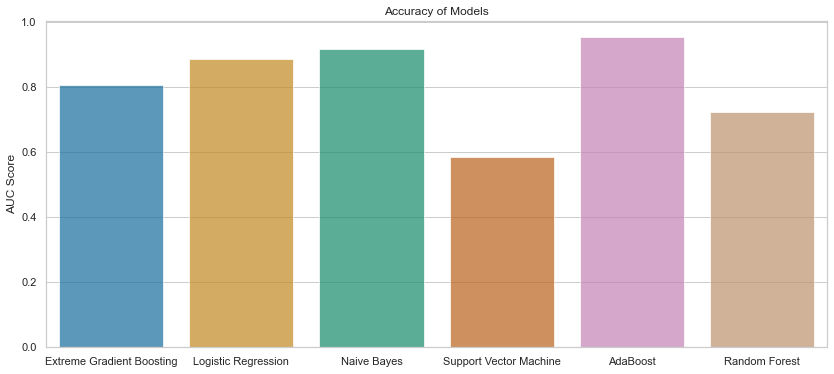

In [22]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="colorblind")
Y_pos = np.arange(len(names))
Y_val = list(all_models_auc.values())
plt.figure(figsize=(14, 6))
sns.barplot(Y_pos,Y_val, alpha=0.7)
plt.xticks(Y_pos, names)
plt.ylabel('AUC Score')
plt.title('Accuracy of Models')
plt.show()

In [23]:
# This is the best model
best_model

{'Name': 'AdaBoost',
 'Model': AdaBoostClassifier(n_estimators=100, random_state=41),
 'AUC Score': 0.9545454545454546,
 'Predictions': array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1], dtype=int64)}

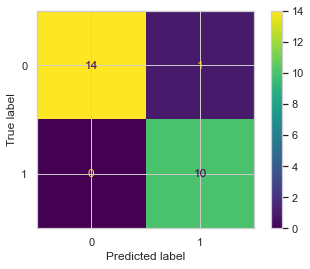

In [24]:
# Confussion matrix for best model
cm = confusion_matrix(test['label'], best_model["Predictions"], labels=best_model["Model"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model["Model"].classes_)
disp.plot()

In [25]:
# save the model to disk
pickle.dump(best_model["Model"], open("BestModelChile.sav", 'wb'))

# Colombia

In [26]:
#Read-In Corpus
corpus_data=pd.read_csv("all_tweets_filtered.csv")

In [27]:
# Obtaining data before and during for politicians and before for celebrities

# Note that the argument time is only for celebrities 
corpus_pol, corpus_cel = df_filter(corpus_data, country="Colombia", time="Before")

In [28]:
# Cleaning tweets
corpus_pol['cleaned_text'] = [cleanTweets(text) for text in corpus_pol['text']]
corpus_cel['cleaned_text'] = [cleanTweets(text) for text in corpus_cel['text']]

In [29]:
del corpus_data

#### First approach - Group text by user

In [30]:
corpus_pol[["author.username", "cleaned_text"]]

,author.username,cleaned_text
555795,IvanDuque,pilares pacto juventud empleo propósito claro ...
555796,IvanDuque,participamos conversatorio organizado presiden...
555797,IvanDuque,#lacforum rendimos homenaje secretario general...
555798,IvanDuque,sabemos grandes retos crecimiento económico re...
555799,IvanDuque,#lacforum destacamos colombia avanza vacunació...
...,...,...
982738,pedrohflorez,alternancia educativa brinda niños jóvenes pos...
982739,pedrohflorez,#prosperidadparatodos \n#biencomún \nbackhand_...
982740,pedrohflorez,"razones vivir cada día máximo plenitud, única ..."
982741,pedrohflorez,aquí nuevamente siempre primer día...


In [31]:
corpus_pol = pd.concat([corpus_pol[["author.username", "Left/Right"]], 
                        corpus_pol[["author.username", "cleaned_text"]].groupby(["author.username"], as_index=False)["cleaned_text"].transform(lambda x: ' '.join(x))], axis=1)

In [32]:
# Drop duplicates and drop na
corpus_pol = corpus_pol.drop_duplicates().dropna()

In [33]:
corpus_pol

,author.username,Left/Right,cleaned_text
555795,IvanDuque,Right,pilares pacto juventud empleo propósito claro ...
556195,petrogustavo,Left,aquí lista senadores votaron moción censura ro...
556986,ClaudiaLopez,Left,esquema reapertura consideramos necesario fren...
557740,JuanManSantos,Left,"lamentamos fallecimiento john jairo ocampo, am..."
557756,AlvaroUribeVel,Right,puedo decir pierdan #elcontrol hoy hoy @userme...
...,...,...,...
980614,ISAZULETA,Left,capitulo leído casi propia historia vida miles...
981386,AlexFlorezH,Left,"través redes, alejandro vásquez solicitó apoyo..."
982080,EsmeHernandezSi,Left,piden listado senadores votaron moción censura...
982142,intiasprilla,Left,#usme recogiendo información sucedió anoche #e...


In [34]:
corpus_pol["Left/Right"].value_counts()

Left     57
Right    54
Name: Left/Right, dtype: int64

In [35]:
# Define dummy variable for left/right
corpus_pol["label"] = [1 if branch=="Right" else 0  for branch in corpus_pol["Left/Right"]]

In [36]:
corpus_pol["label"].value_counts()

0    57
1    54
Name: label, dtype: int64

In [37]:
# Create train, test set
train, test = train_test_split(corpus_pol, test_size=0.3, train_size=0.7, random_state=14)
train.shape, test.shape

((77, 4), (34, 4))

In [38]:
models = [
          XGBClassifier(random_state=41, n_estimators=100, max_depth=2, learning_rate=0.1, eval_metric="error", gamma=3, min_child_weight=6), # Extreme Gradient Boosting
          LogisticRegression(), # Logistic Regression 
          MultinomialNB(alpha = 1, fit_prior = True), # Naive Bayes
          SVC(C=3), # Support Vector Machine
          AdaBoostClassifier(n_estimators = 100, random_state=41), # AdaBoost
          RandomForestClassifier(n_estimators=300, max_depth=3)  
          ]

names = ["Extreme Gradient Boosting", "Logistic Regression", "Naive Bayes", 
         "Support Vector Machine", "AdaBoost", "Random Forest"]



# Train models, get best model, get scores of each model using CountVectorizer
best_model, all_models_auc = models_performance(train, test, "cv", models)

Evaluation metrics for Extreme Gradient Boosting
Accuracy Score : 0.7941176470588235
Recall Score : 0.9333333333333333
F1 Score : 0.8
AUC  :    0.8087719298245615
 
 
Evaluation metrics for Logistic Regression
Accuracy Score : 0.7058823529411765
Recall Score : 0.8666666666666667
F1 Score : 0.7222222222222222
AUC  :    0.7228070175438597
 
 
Evaluation metrics for Naive Bayes
Accuracy Score : 0.8823529411764706
Recall Score : 1.0
F1 Score : 0.8823529411764706
AUC  :    0.8947368421052632
 
 
Evaluation metrics for Support Vector Machine
Accuracy Score : 0.6470588235294118
Recall Score : 1.0
F1 Score : 0.7142857142857143
AUC  :    0.6842105263157895
 
 
Evaluation metrics for AdaBoost
Accuracy Score : 0.7352941176470589
Recall Score : 0.6666666666666666
F1 Score : 0.689655172413793
AUC  :    0.7280701754385964
 
 
Evaluation metrics for Random Forest
Accuracy Score : 0.6764705882352942
Recall Score : 1.0
F1 Score : 0.7317073170731707
AUC  :    0.7105263157894737
 
 


In [39]:
all_models_auc

{'Extreme Gradient Boosting': 0.8142857142857143,
 'Logistic Regression': 0.7326007326007327,
 'Naive Bayes': 0.8947368421052632,
 'Support Vector Machine': 0.7777777777777778,
 'AdaBoost': 0.7321428571428572,
 'Random Forest': 0.7884615384615384}

In [40]:
best_model, all_models_auc = models_performance(train, test, "tfidf", models)

Evaluation metrics for Extreme Gradient Boosting
Accuracy Score : 0.7647058823529411
Recall Score : 0.9333333333333333
F1 Score : 0.7777777777777778
AUC  :    0.7824561403508772
 
 
Evaluation metrics for Logistic Regression
Accuracy Score : 0.8823529411764706
Recall Score : 1.0
F1 Score : 0.8823529411764706
AUC  :    0.8947368421052632
 
 
Evaluation metrics for Naive Bayes
Accuracy Score : 0.9117647058823529
Recall Score : 1.0
F1 Score : 0.9090909090909091
AUC  :    0.9210526315789473
 
 
Evaluation metrics for Support Vector Machine
Accuracy Score : 0.9117647058823529
Recall Score : 1.0
F1 Score : 0.9090909090909091
AUC  :    0.9210526315789473
 
 
Evaluation metrics for AdaBoost
Accuracy Score : 0.8823529411764706
Recall Score : 1.0
F1 Score : 0.8823529411764706
AUC  :    0.8947368421052632
 
 
Evaluation metrics for Random Forest
Accuracy Score : 0.7352941176470589
Recall Score : 0.9333333333333333
F1 Score : 0.7567567567567568
AUC  :    0.7561403508771931
 
 


In [41]:
all_models_auc

{'Extreme Gradient Boosting': 0.7948717948717948,
 'Logistic Regression': 0.8947368421052632,
 'Naive Bayes': 0.9166666666666667,
 'Support Vector Machine': 0.9166666666666667,
 'AdaBoost': 0.8947368421052632,
 'Random Forest': 0.7765151515151514}

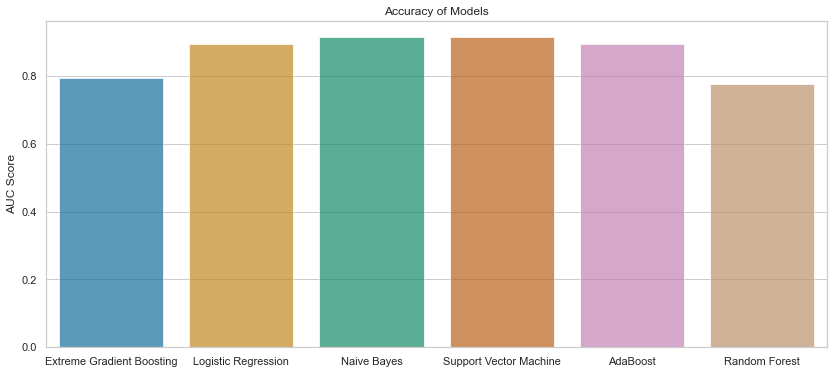

In [42]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="colorblind")
Y_pos = np.arange(len(names))
Y_val = list(all_models_auc.values())
plt.figure(figsize=(14, 6))
sns.barplot(Y_pos,Y_val, alpha=0.7)
plt.xticks(Y_pos, names)
plt.ylabel('AUC Score')
plt.title('Accuracy of Models')
plt.show()

In [43]:
# This is the best model
best_model

{'Name': 'Naive Bayes',
 'Model': MultinomialNB(alpha=1),
 'AUC Score': 0.9166666666666667,
 'Predictions': array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0], dtype=int64)}

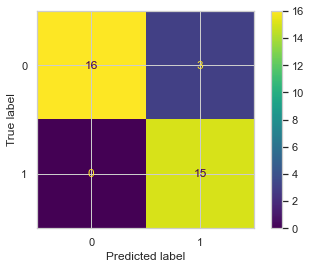

In [44]:
# Confussion matrix for best model
cm = confusion_matrix(test['label'], best_model["Predictions"], labels=best_model["Model"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model["Model"].classes_)
disp.plot()

In [45]:
# save the model to disk
pickle.dump(best_model["Model"], open("BestModelColombia.sav", 'wb'))